# Credit Risk Machine Learning Model

Credit modelling is an important part of determining risk when offering loans to potential borrowers. If a borrower does not pay their loan back on time, the investor will lose money.

In a previous notebook I have taken Lending Club data from 2007 to 2011 and cleaned it. In this notebook I will be building the machine learning model to predict whether a borrower will pay back in time.

The machine learning model will be built from a conservative investors perspective, hoping to invest (predict) only in loans that will have a good chance of being paid off on time. In this regard we are interested in the true positive rate. However the false positive rate is also very important as we do not want to invest in a loan that will not be paid back. It is important to have a good trade off between these rates, as often improving one worsens the other. We will measure the performance of the model through ROC curves and confusion matrices.

## Exploring the Data

In [43]:
# importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTENC
%matplotlib inline

In [2]:
loans = pd.read_csv('clean_loans_2007.csv')
loans.drop('Unnamed: 0', axis=1, inplace=True)
loans.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies
0,5000.0,36 months,10.65%,162.87,10+ years,RENT,24000.0,Verified,1,credit_card,...,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,Jun-2016,0.0
1,2500.0,60 months,15.27%,59.83,< 1 year,RENT,30000.0,Source Verified,0,car,...,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,Sep-2013,0.0
2,2400.0,36 months,15.96%,84.33,10+ years,RENT,12252.0,Not Verified,1,small_business,...,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,Jun-2016,0.0
3,10000.0,36 months,13.49%,339.31,10+ years,RENT,49200.0,Source Verified,1,other,...,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,Apr-2016,0.0
4,5000.0,36 months,7.90%,156.46,3 years,RENT,36000.0,Source Verified,1,wedding,...,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3%,12.0,Jan-2016,0.0


## Removing Null Values

In [3]:
# find number of null values in each column
null_counts = loans.isnull().sum()

# filter only for counts > 0
null_counts[null_counts != 0]

emp_length              1036
title                     11
revol_util                50
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64

*emp_length* and *pub_rec_bankruptcies* have a relatively large number of missing values. Employment length is important in determining credit risk, so we should keep this feature.

In [4]:
loans['pub_rec_bankruptcies'].value_counts(normalize=True, dropna=False)

0.0    0.939438
1.0    0.042456
NaN    0.017978
2.0    0.000129
Name: pub_rec_bankruptcies, dtype: float64

*pub_rec_bankruptcies* offers little variability, so we can drop this col.

In [5]:
loans.drop('pub_rec_bankruptcies', axis=1, inplace=True)
loans.dropna(axis=0, inplace=True)

## Dropping non-Numerical Features

In [6]:
# check data types in dataframe
loans.dtypes.value_counts()

object     11
float64    10
int64       1
dtype: int64

In [7]:
# create new dataframe of only object types and print
objects = loans.select_dtypes('object')
objects.head(1)

,term,int_rate,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,10+ years,RENT,Verified,credit_card,Computer,AZ,Jan-1985,83.7%,Jun-2016


Consulting the data dictionary it was found:

- *home_ownership* - can be only 1 of 4 categorical values
- *verification_status* - indicates if the income was verified by Lending Club
- *emp_length* - number of years the borrower was employed upon time of application
- *term* - number of payments on the loan, either 36 or 60
- *addr_state* - borrower's state of residence
- *purpose* - provided by the borrower
- *title* - loan title provided by the borrower
- *int_rate* - interest rate of the loan in %
- *revol_util* - revolving line utilisation rate or the amoun of redit the borrower is using relative to all available credit
- *earliest_cr_line* - the month the borrower/s earliest reported credit line was opened
- *last_credit_pull_d* - the most recent month Lending Club pulled credit for this loan

It looks like *purpose* and *title* reflect the same information.

The date columns will require significant feature engineering for a potentially unequivalent gain.

The *int_rate* and *revol_util* cols contain numerical information and need to be converted.

Exploring the other columns:

In [8]:
# list of cols to explore
object_cols = ['home_ownership',
               'verification_status',
               'emp_length',
               'term',
               'addr_state']

# print normalised value counts of cols to explore
for col in object_cols:
    print(loans[col].value_counts(normalize=True), '\n')

RENT        0.480743
MORTGAGE    0.442893
OWN         0.073736
OTHER       0.002548
NONE        0.000080
Name: home_ownership, dtype: float64 

Not Verified       0.432143
Verified           0.314691
Source Verified    0.253165
Name: verification_status, dtype: float64 

10+ years    0.226808
< 1 year     0.119788
2 years      0.114214
3 years      0.106755
4 years      0.088998
5 years      0.084990
1 year       0.084300
6 years      0.057784
7 years      0.045494
8 years      0.038275
9 years      0.032595
Name: emp_length, dtype: float64 

 36 months    0.749409
 60 months    0.250591
Name: term, dtype: float64 

CA    0.179854
NY    0.095926
FL    0.071772
TX    0.069356
NJ    0.047140
IL    0.038407
PA    0.038275
VA    0.035753
GA    0.035116
MA    0.033762
OH    0.030498
MD    0.026755
AZ    0.021420
WA    0.020916
CO    0.019854
NC    0.019350
CT    0.018872
MI    0.017996
MO    0.017200
MN    0.015421
NV    0.012369
SC    0.012050
WI    0.011334
OR    0.011201
LA    0.011148
A

These columns contain multiple discrete values that need to be encoded. The *emp_length* column also needs to be cleaned.

Exploring the *purpose* and *title* columns confirms that they contain similar information. However *purpose* contains fewer discrete values so we shall remove *title*.

In [9]:
print(loans['title'].value_counts(normalize=True), '\n')
print(loans['purpose'].value_counts(normalize=True))

Debt Consolidation         0.054891
Debt Consolidation Loan    0.042442
Personal Loan              0.016563
Consolidation              0.012953
debt consolidation         0.012369
                             ...   
Out of Luck                0.000027
Debt Free by 45            0.000027
Getting out of debt!!!     0.000027
Licensing and inventory    0.000027
Eye On the Prize           0.000027
Name: title, Length: 18881, dtype: float64 

debt_consolidation    0.471161
credit_card           0.130352
other                 0.098500
home_improvement      0.074532
major_purchase        0.055289
small_business        0.045627
car                   0.038726
wedding               0.024313
medical               0.017386
moving                0.014652
house                 0.009449
vacation              0.009237
educational           0.008281
renewable_energy      0.002495
Name: purpose, dtype: float64


In [10]:
# drop features
loans.drop(['last_credit_pull_d',
            'addr_state',
            'title',
            'earliest_cr_line'], axis=1, inplace=True)

In [11]:
# clean emp_length column using mapping dict
mapping = {'10+ years': 10,
           '9 years': 9,
           '8 years': 8,
           '7 years': 7,
           '6 years': 6,
           '5 years': 5,
           '4 years': 4,
           '3 years': 3,
           '2 years': 2,
           '1 year': 1,
           '< 1 year': 0,
           "n/a":0
          }

# map dict to emp_length column
loans['emp_length'].replace(mapping, inplace=True)

In [12]:
# clean and format int_rate and revol_util cols
loans['int_rate'] = loans['int_rate'].str.strip('%').astype('float')
loans['revol_util'] = loans['revol_util'].str.strip('%').astype('float')

### Checking Collinearity

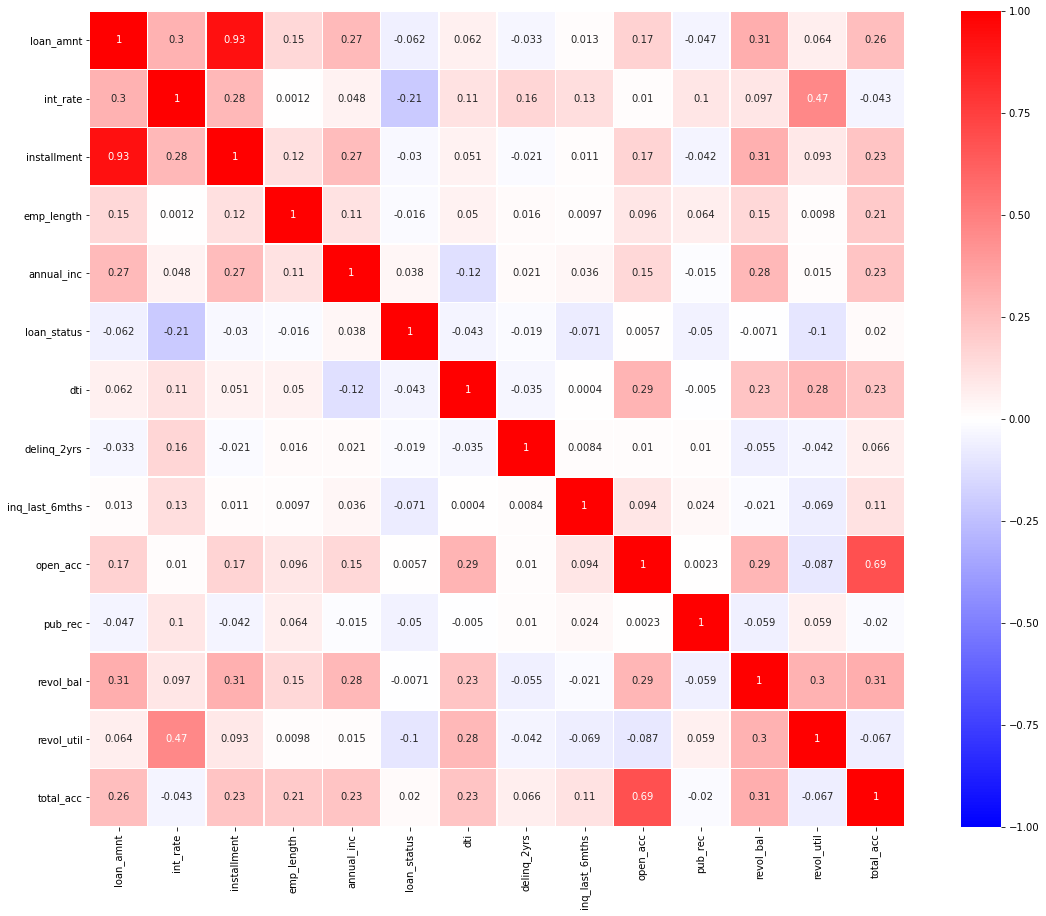

In [13]:
# plot heatmap of correlation between features
plt.figure(figsize=(20,15))
sns.heatmap(loans.corr(), annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=0.5)

There seems to be a strong correlation between *loan_amnt* and *installment*, we will drop the *installment* feature.

In [14]:
loans.drop(['installment'], axis=1, inplace=True)

### Creating Dummy Variables

It is now necessary to convert the categorical variables to dummy variables.

In [15]:
# set variables to categorical type
cols = [
    'home_ownership',
    'verification_status',
    'purpose',
    'term'
]

for col in cols:
    loans[col] = loans[col].astype('category')

# create dummy variables for the categorical features
loans = pd.concat([loans,
                 pd.get_dummies(loans[['home_ownership',
                                       'verification_status',
                                       'purpose',
                                      'term']])], axis=1)

# drop original cols
loans.drop(['home_ownership',
            'verification_status',
            'purpose',
            'term'], axis=1, inplace=True)

In [16]:
# check dataframe info
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37675 entries, 0 to 38769
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            37675 non-null  float64
 1   int_rate                             37675 non-null  float64
 2   emp_length                           37675 non-null  int64  
 3   annual_inc                           37675 non-null  float64
 4   loan_status                          37675 non-null  int64  
 5   dti                                  37675 non-null  float64
 6   delinq_2yrs                          37675 non-null  float64
 7   inq_last_6mths                       37675 non-null  float64
 8   open_acc                             37675 non-null  float64
 9   pub_rec                              37675 non-null  float64
 10  revol_bal                            37675 non-null  float64
 11  revol_util                  

# Building the Model

The algorithm will make predictions about whether or not a loan will be paid off on time, which is contained in the *loan_status* column of the clean dataset. The problem is therefore a binary classification problem.

The *loan_status* column has a significant class imbalance: there are 6 times as many loans that were paid off on time (labelled 1) than those that weren't (labelled 0).

Due to this, the true positive rate and false positive rate are important to test our model. In context:

- *true positive rate* - the model has correctly predicted whether a loan will be paid off on time, we will not lose money by investing
- *false positive rate* - the model has incorrectly predicted that a loan will be paid off on time when it won't be, we will lose money by investing

Ideally we need to maximise the true positive rate and minimise the false positive rate, corresponding to a high AUC score which will therefore be the error metric we will use.

The classification models we will use are:

- logistic regression
- random forests
- linear discriminant analysis

We will quickly fit basic models to the training set and validate on the test set to discover which models to take forward for further model complexity where we can then explore better validation techniques.

### Splitting Test and Training Datasets

We will split the dataset into a 70:30 train test split.

In [17]:
# identify feature and target matrices
features = loans[loans.columns.drop('loan_status')]
target = loans['loan_status']

# split dataset into train and test splits
X_train_master, X_test, y, y_test = train_test_split(features, target, train_size=0.7, random_state=1)

### Scaling Numerical Features

The numerical features will be scaled to zero mean and unit variance. The same transformation will be applied on the test set data for consistency.

In [18]:
# suppress settingwithcopy warning
pd.options.mode.chained_assignment = None

# create a copy of the master train data to perform scaling on
X = X_train_master.copy()

# identify numerical columns to be standardised
numerical = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')].tolist()

# standardise numerical features in training dataset
scaler = StandardScaler()
X[numerical] = scaler.fit_transform(X[numerical])

# apply identical transformation to test set for consistency
X_test[numerical] = scaler.fit_transform(X_test[numerical])

# Model Selection

In [19]:
# models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forests': RandomForestClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Linear Discriminant': LinearDiscriminantAnalysis()
}

# empty dict for scoring data
scoring = {}
rocs = {}
confs = {}

# for each model calculate average auc score, roc curve and tp and fp for confusion matrix
for i in models.keys():
    
    scores = cross_val_score(models[i], X, y, scoring='roc_auc', cv=3)
    scoring[i] = np.mean(scores)
    
    models[i].fit(X, y)
    
    probs = models[i].predict_proba(X_test)
    
    fp, tp, threshold = roc_curve(y_test, probs[:,1])
    rocs[i] = {'fps': fp, 'tps': tp}
    
    conf = confusion_matrix(y_test, models[i].predict(X_test)).T
    conf = conf.astype('float') / conf.sum(axis=0)
    confs[i] = conf
    

                      auc_score
Logistic Regression    0.698977
Linear Discriminant    0.695437
Random Forests         0.684968
Gaussian Naive Bayes   0.644554


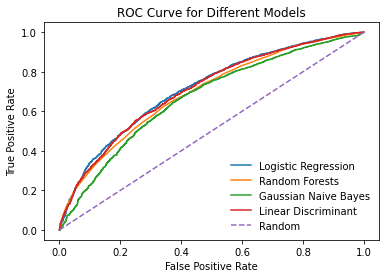

In [35]:
# plot ROC curves
fig = plt.figure()
ax = plt.axes()

for i in models.keys():
    ax.plot(rocs[i]['fps'], rocs[i]['tps'], label=i)

plt.plot([0,1], [0,1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(frameon=False)

# show auc score results
print(pd.DataFrame.from_dict(scoring, orient='index', columns=['auc_score']).sort_values(by='auc_score', ascending=False))

Text(0.04, 0.5, 'Predicted Value')

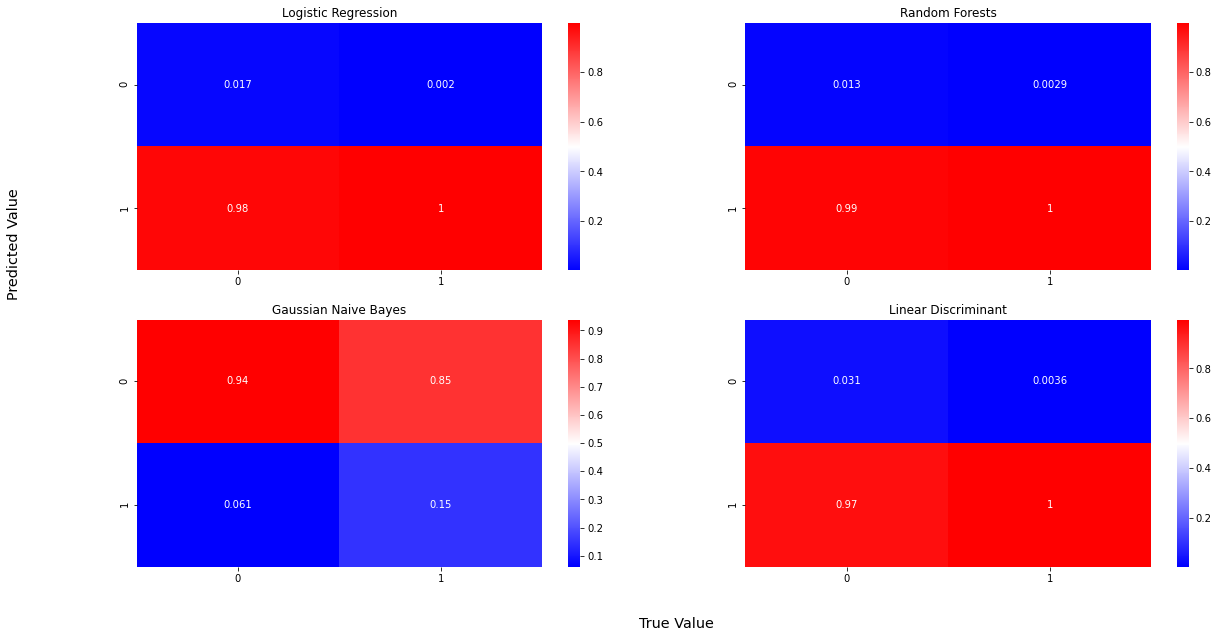

In [21]:
# plot confusion matrices
fig, ax = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(20)

sns.heatmap(confs['Logistic Regression'], annot=True, cmap='bwr', ax=ax[0,0])
sns.heatmap(confs['Random Forests'], annot=True, cmap='bwr', ax=ax[0,1])
sns.heatmap(confs['Gaussian Naive Bayes'], annot=True, cmap='bwr', ax=ax[1,0])
sns.heatmap(confs['Linear Discriminant'], annot=True, cmap='bwr', ax=ax[1,1])

ax[0,0].set_title('Logistic Regression')
ax[0,1].set_title('Random Forests')
ax[1,0].set_title('Gaussian Naive Bayes')
ax[1,1].set_title('Linear Discriminant')
fig.text(0.5, 0.04, 'True Value', ha='center', fontsize='x-large')
fig.text(0.04, 0.5, 'Predicted Value', ha='center', fontsize='x-large', rotation='vertical')

Investigating the results, we can see that the Logistic Regression model performed the best out of the 4 models with regards to its AUC score. 

Considering the confusion matrix however we can see that the false positive rate is quite high, which is not good in the context of investing in loans that won't be paid back on time

There are several techniques we can include such as grid searching, threshold-moving and sampling techniques to optimise the logistic regression model.

# Logistic Regression Optimisation

Lets perform a grid search on the logistic regression model using different *class_weight* penalties, *solver* types and *C* regularisation penalties.

In [22]:
y.value_counts(normalize=True)

1    0.858752
0    0.141248
Name: loan_status, dtype: float64

In [23]:
hyperparameters = {
    'class_weight': ['balanced', {0: 8, 1: 1}, {0: 10, 1: 1}],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'C': [0.3, 0.5, 1]
}

grid = GridSearchCV(models['Logistic Regression'], param_grid=hyperparameters, cv=3, scoring='roc_auc')
grid.fit(X, y)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.3, 0.5, 1],
                         'class_weight': ['balanced', {0: 8, 1: 1},
                                          {0: 10, 1: 1}],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')

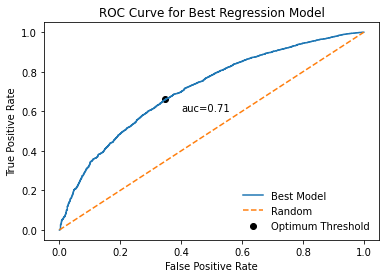

In [24]:
grid.best_estimator_.fit(X, y)

probs_best = grid.best_estimator_.predict_proba(X_test)

fp, tp, threshold = roc_curve(y_test, probs_best[:,1])
auc = roc_auc_score(y_test, probs_best[:,1])

gmeans = (tp * (1-fp))**0.5
ix = np.argmax(gmeans)
opt_threshold = threshold[ix]

conf = confusion_matrix(y_test, grid.best_estimator_.predict(X_test)).T
conf = conf.astype('float') / conf.sum(axis=0)

fig = plt.figure()
ax = plt.axes()
ax.plot(fp, tp, label='Best Model')
ax.plot([0,1], [0,1], linestyle='--', label='Random')
ax.text(0.4, 0.6, 'auc={}'.format(round(auc,2)))
ax.scatter(fp[ix], tp[ix], marker='o', color='black', label='Optimum Threshold')
ax.set_title('ROC Curve for Best Regression Model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.legend(loc='lower right', frameon=False)

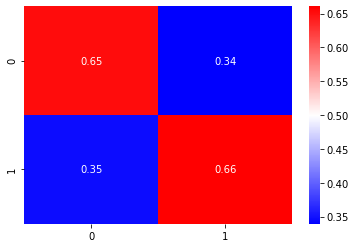

In [25]:
predict = np.where(probs_best[:,1] >= opt_threshold, 1, 0)

conf = confusion_matrix(y_test, predict).T
conf = conf.astype('float') / conf.sum(axis=0)
sns.heatmap(conf, annot=True, cmap='bwr')

### Synthetic Minority Oversampling

In [32]:
categoricals = [i for i in range(13,36)]
oversampler = SMOTENC(categorical_features=categoricals, sampling_strategy='minority')
X_resampled, y_resampled = oversampler.fit_resample(X_train_master, y)
numerical = X_resampled.columns[(X_resampled.dtypes == 'float64') | (X_resampled.dtypes == 'int64')].tolist()

X_resampled[numerical] = scaler.fit_transform(X_resampled[numerical])

In [33]:
y_resampled.value_counts()

1    22647
0    22647
Name: loan_status, dtype: int64

Text(0.5, 1.0, 'Confusion Matrix for Best Regression Model')

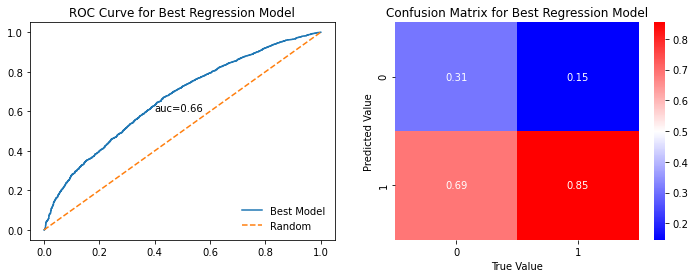

In [42]:
grid.best_estimator_.fit(X_resampled, y_resampled)

probs_resampled = grid.best_estimator_.predict_proba(X_test)

fp, tp, _ = roc_curve(y_test, probs_resampled[:,1])
auc = roc_auc_score(y_test, probs_resampled[:,1])

predict = np.where(probs_resampled[:,1] >= opt_threshold, 1, 0)

conf = confusion_matrix(y_test, predict).T
conf = conf.astype('float') / conf.sum(axis=0)

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
ax[0].plot(fp, tp, label='Best Model')
ax[0].plot([0,1], [0,1], linestyle='--', label='Random')
ax[0].text(0.4, 0.6, 'auc={}'.format(round(auc, 2)))
ax[0].set_title('ROC Curve for Best Regression Model')
ax[0].legend(loc='lower right', frameon=False)
sns.heatmap(conf, annot=True, cmap='bwr', ax=ax[1])
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')
ax[1].set_title('Confusion Matrix for Best Regression Model')

Applying SMOTE improved the true positive rate, but increased the false positive rate. The true positive rate is quite high which is good, so depending on the mindset of the investor this could be a good model to use. The previous model had a better false positive rate however.

# Conclusion

In this project I have explored the possibility of predicting whether a borrow will pay back a loan on time using Lending Club data and machine learning techniques. The dataset was imbalanced with a positive class imbalance of 6:1.

It was found that logistic regression was the best model. Applying a grid search acheived an AUC score of 0.71, with good true positive and true negative rates. Further applying SMOTE improved the true positive rate but worsened the false positive rate. Depending on the mindset of the investor, the best model is probably that without applying SMOTE as it has a good balance of true positive and negative rate. 